# wave - eddy interactions - the horizontal fluxes

The equation describing the rate of change of total $E$ energy for a QG mean flow $\pmb{u}$, and internal wave perterbations $\pmb{u}^\prime$, is the following:

$$(\frac{\partial}{\partial t}  + \overline{\pmb{u}} \cdot \nabla) E + \nabla \cdot {\overline{\phi^\prime \pmb{u}^\prime}} = - \frac{1}{2} (\overline{u^\prime u^\prime} - \overline{\upsilon^\prime \upsilon^\prime}) S_n - \overline{u^\prime \upsilon^\prime} S_s - (\overline{u^\prime w^\prime} - f N^{-2} \overline{b^\prime \upsilon^\prime}) \frac{\partial \overline{u}}{\partial z} - ( \overline{\upsilon^\prime w^\prime} + f N^{-2} \overline{b^\prime u^\prime}) \frac{\partial \overline{\upsilon}}{\partial z} $$

Many important approximations have lead to this equation, including:
1. f-plane
1. linear internal waves
  1. implies no vertical buoyancy flux
1. quasi-geostrophic mean flow (low $Ro$)
  1. implies thermal wind balance
  1. implies vertical velocity of mean flow negligibly small

The transfer terms involving horizontal stress and strain are:

$$ - \frac{1}{2} (\overline{u^\prime u^\prime} - \overline{\upsilon^\prime \upsilon^\prime}) S_n - \overline{u^\prime \upsilon^\prime} S_s $$

where

$$S_n = \frac{\partial \overline{u}}{\partial x} - \frac{\partial \overline{\upsilon}}{\partial y}$$

and

$$S_s =  \frac{\partial \overline{\upsilon}}{\partial x} + \frac{\partial \overline{u}}{\partial y}$$


In [3]:
import os

import gsw
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as itgr
from matplotlib.gridspec import GridSpec

import convenience_funcs as cfs

# My own functions
import load_data
import munch
import utils

matplotlib.rc("font", size=7)
matplotlib.rc("axes", titlepad=1)

save_figs = True

pdd = "../data"
fsd = "../figures"
data_in = pdd

M2 = 24.0 / 12.4206012

moorings = load_data.load_my_data()
ca, cw = load_data.load_my_data_alt()
ca = munch.munchify(ca)
cw = munch.munchify(cw)

moorings = [munch.munchify(m) for m in moorings]

cc, nw, ne, se, sw = moorings

ADCP = utils.loadmat(os.path.join(data_in, "ADCP.mat"))
ADCP = munch.munchify(ADCP)

topo = utils.loadmat(os.path.join(data_in, "topo_info.mat"))
topo = munch.munchify(topo)

## Time series and time mean of horizontal energy flux

Horizontal transfer at 566 m is 2.926e-10 +/- 2.301e-10 W/kg
Horizontal transfer at 1243 m is 8.552e-11 +/- 9.130e-11 W/kg
Horizontal transfer at 2084 m is 1.795e-10 +/- 7.588e-11 W/kg
Horizontal transfer at 3388 m is -1.396e-10 +/- 8.144e-11 W/kg


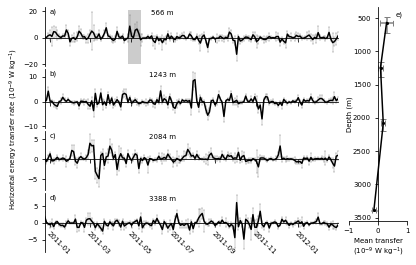

In [9]:
t0 = 734619
t1 = 734639
#####################################
m = ca

fig = plt.figure(figsize=(6.5, 4.5))
gs = GridSpec(m.N_levels * 2, 2, width_ratios=[5, 1], hspace=0.1, wspace=0.06)
axs = [plt.subplot(gs[i * 2 : (i + 1) * 2, 0]) for i in range(m.N_levels)]
axp = plt.subplot(gs[:-1, 1])

for ax in axs[:-1]:
    ax.set_xticklabels([])

# Simplify plots
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_position("zero")

axp.spines["top"].set_visible(False)
axp.spines["right"].set_visible(False)
axp.spines["left"].set_position("zero")

F = np.full_like(m.dudz, np.nan)
F_err = 1.96 * utils.emean(m.errF_horiz)

for lev in range(m.N_levels):
    tdt = m.tdt[:, lev]
    nstrain = m.nstrain[:, lev]
    sstrain = m.sstrain[:, lev]
    uu = m.Puu_int[:, lev]
    vv = m.Pvv_int[:, lev]
    uv = m.Cuv_int[:, lev]

    F_horiz = -0.5 * (uu - vv) * nstrain - uv * sstrain

    F[:, lev] = F_horiz

    # Useful numbers:
    print(
        "Horizontal transfer at {:1.0f} m is {:1.3e} +/- {:1.3e} W/kg"
        "".format(-m.z[:, lev].mean(), F_horiz.mean(), F_err[lev])
    )

    axs[lev].set_xlim(tdt[0], tdt[-1])
    axs[lev].errorbar(
        tdt,
        1e9 * F_horiz,
        yerr=1e9 * 1.96 * m.errF_horiz[:, lev],
        ecolor="grey",
        capsize=1,
        color="k",
        elinewidth=0.4,
        capthick=0.4,
    )

    axs[lev].annotate(
        "{:1.0f} m".format(-m.z[:, lev].mean()),
        xy=(0.4, 0.9),
        xycoords="axes fraction",
        ha="center",
        va="center",
    )

yerr = np.abs(np.percentile(-ca.z, [10, 90], axis=0) + m.z.mean(axis=0))

axp.errorbar(
    1e9 * F.mean(axis=0),
    -m.z.mean(axis=0),
    xerr=1e9 * F_err,
    yerr=yerr,
    fmt="o-",
    capsize=3,
    ecolor="grey",
    color="k",
    markersize=2,
)
axp.set_xlim(-1, 1.0)
# axp.axvline(0, color='k', linewidth=1)
axp.set_xlabel("Mean transfer\n($10^{-9}$ W kg$^{-1}$)")
axp.set_ylabel("Depth (m)", labelpad=-0.5)
axp.invert_yaxis()

cfs.ylabel(
    "Horizontal energy transfer rate ($10^{-9}$ W kg$^{-1}$)",
    fig,
    axs[1],
    axs[2],
    -0.08,
)
# axs[2].set_ylabel("Horizontal energy transfer rate ($10^{-9}$ W kg$^{-1}$)")

cfs.axes_labels(
    fig,
    axs,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.01,
    dy=-0.02,
)
cfs.axes_labels(
    fig,
    axp,
    i0=4,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.1,
    dy=-0.03,
)

axs[0].fill_betweenx(
    axs[0].get_ylim(),
    utils.datenum_to_datetime(t0),
    utils.datenum_to_datetime(t1),
    color="k",
    alpha=0.2,
    linewidth=0,
)
plt.setp(
    axs[-1].xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor"
)

if save_figs:
    fig_name = "horizontal_energy_flux_all_levels.pdf"
    fig.savefig(os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0)
    fig_name = "horizontal_energy_flux_all_levels.png"
    fig.savefig(os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0)


plt.show()

### Compare contributions from normal and shear components

In [10]:
m = ca
for lev in range(m.N_levels):
    tdt = m.tdt[:, lev]
    nstrain = m.nstrain[:, lev]
    sstrain = m.sstrain[:, lev]
    uu = m.Puu_int[:, lev]
    vv = m.Pvv_int[:, lev]
    uv = m.Cuv_int[:, lev]

    F_norm = -0.5 * (uu - vv) * nstrain
    F_shear = -uv * sstrain

    print(
        "Depth {:1.0f} m, mean F_norm {:1.1e} W/kg, mean F_shear {:1.1e} W/kg".format(
            -ca.z[:, lev].mean(), F_norm.mean(), F_shear.mean()
        )
    )

Depth 566 m, mean F_norm -4.2e-11 W/kg, mean F_shear 3.3e-10 W/kg
Depth 1243 m, mean F_norm -3.3e-11 W/kg, mean F_shear 1.2e-10 W/kg
Depth 2084 m, mean F_norm 1.1e-10 W/kg, mean F_shear 6.5e-11 W/kg
Depth 3388 m, mean F_norm -2.7e-10 W/kg, mean F_shear 1.3e-10 W/kg


## Zoom on a slice

z mean: -519.3435350156958 m
u mean 0.14843238665971864 m/s
v mean -0.016747681083897858 m/s


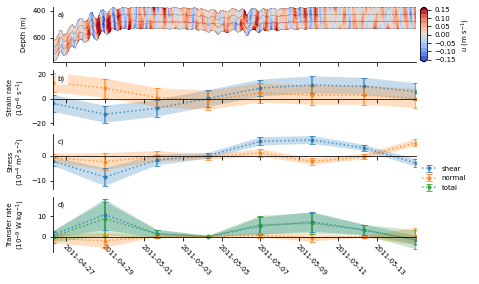

In [11]:
t0 = 734619
t1 = 734639
lev = 0
levr = 2

t = cc.t[:, levr]
use = (t > t0) & (t < t1)
tm = ca.t[:, lev]
usem = (tm > t0) & (tm < t1)


def esum(ea, eb):
    return np.sqrt(ea ** 2 + eb ** 2)


# Energy stuff
tdt = cc.tdt[use, levr]
tdtm = ca.tdt[usem, lev]
z = ca.z[usem, lev]
u = cc.u[use, levr]
v = cc.v[use, levr]
nstrain = ca.nstrain[usem, lev]
sstrain = ca.sstrain[usem, lev]
sserr = 1.96 * ca.esstrain[usem, lev]  # 95% estimate using 1.96 factor
nserr = 1.96 * ca.enstrain[usem, lev]
uverr = 1.96 * ca.euv[usem, lev]
uuvverr = 1.96 * ca.enstress[usem, lev]
uu = ca.Puu_int[usem, lev]
vv = ca.Pvv_int[usem, lev]
uv = ca.Cuv_int[usem, lev].real
F_horiz = -0.5 * (uu - vv) * nstrain - uv * sstrain
errF_horiz = 1.96 * ca.errF_horiz[usem, lev]
errF_horiz_norm = 1.96 * ca.errF_horiz_norm[usem, lev]
errF_horiz_shear = 1.96 * ca.errF_horiz_shear[usem, lev]

print("z mean: {} m".format(z.mean()))

# Raw stuff
urhi = cc.u_hi[use, 0:4]
# vrhi = cc.v_hi[use, 0:4]
zr = cc.z[use, 0:4]
tr = cc.tdt[use, 0:4]

print("u mean {} m/s".format(cc.u[use, 0:4].mean()))
print("v mean {} m/s".format(cc.v[use, 0:4].mean()))

fig, axs = plt.subplots(
    4, 1, sharex=True, figsize=(6.5, 4.5), gridspec_kw={"hspace": 0.15}
)

C = axs[0].contourf(
    tr, -zr, urhi, np.arange(-0.15, 0.175, 0.025), cmap="coolwarm", extend="both"
)

axs[0].set_xlim(tdtm[0], tdtm[-1])

axs[0].invert_yaxis()
axs[0].plot(tr, -zr, "k:", linewidth=0.5)
axs[0].plot(tdtm, -z, "r:", linewidth=0.5)

c = 1e6

axs[1].errorbar(
    tdtm,
    sstrain * c,
    yerr=c * sserr,
    label="shear",
    capsize=3,
    alpha=0.75,
    ls=":",
    marker="o",
    markersize=3,
)
axs[1].errorbar(
    tdtm,
    nstrain * c,
    yerr=c * nserr,
    label="normal",
    capsize=3,
    alpha=0.75,
    ls=":",
    marker="o",
    markersize=3,
)
axs[1].fill_between(tdtm, c * (sstrain - sserr), c * (sstrain + sserr), alpha=0.25)
axs[1].fill_between(tdtm, c * (nstrain - nserr), c * (nstrain + nserr), alpha=0.25)
axs[1].set_ylabel("Strain rate\n($10^{-6}$ s$^{-1}$)")
# axs[1].set_ylim(-1, 12)

c = 1e4
axs[2].errorbar(
    tdtm,
    -uv * c,
    yerr=c * uverr,
    label="shear",
    capsize=3,
    alpha=0.75,
    ls=":",
    marker="o",
    markersize=3,
)
axs[2].errorbar(
    tdtm,
    -0.5 * (uu - vv) * c,
    yerr=c * uuvverr,
    label="normal",
    capsize=3,
    alpha=0.75,
    ls=":",
    marker="o",
    markersize=3,
)
axs[2].fill_between(tdtm, c * (-uv - uverr), c * (-uv + uverr), alpha=0.25)
axs[2].fill_between(
    tdtm, c * (-0.5 * (uu - vv) - uuvverr), c * (-0.5 * (uu - vv) + uuvverr), alpha=0.25
)
axs[2].set_ylabel("Stress\n($10^{-4}$ m$^2$ s$^{-2}$)")

c = 1e9
axs[3].errorbar(
    tdtm,
    -uv * sstrain * c,
    yerr=c * errF_horiz_shear,
    label="shear",
    capsize=3,
    alpha=0.75,
    ls=":",
    marker="o",
    markersize=3,
)
axs[3].errorbar(
    tdtm,
    -0.5 * (uu - vv) * nstrain * c,
    yerr=c * errF_horiz_norm,
    label="normal",
    capsize=3,
    alpha=0.75,
    ls=":",
    marker="o",
    markersize=3,
)
axs[3].errorbar(
    tdtm,
    F_horiz * c,
    yerr=c * errF_horiz,
    label="total",
    capsize=3,
    alpha=0.75,
    ls=":",
    marker="o",
    markersize=3,
)
axs[3].fill_between(
    tdtm,
    c * (-uv * sstrain - errF_horiz_shear),
    c * (-uv * sstrain + errF_horiz_shear),
    alpha=0.25,
)
axs[3].fill_between(
    tdtm,
    c * (-0.5 * (uu - vv) * nstrain - errF_horiz_norm),
    c * (-0.5 * (uu - vv) * nstrain + errF_horiz_norm),
    alpha=0.25,
)
axs[3].fill_between(
    tdtm, c * (F_horiz - errF_horiz), c * (F_horiz + errF_horiz), alpha=0.25,
)

axs[3].set_ylabel("Transfer rate\n($10^{-9}$ W kg$^{-1}$)")
axs[3].legend(loc=3, bbox_to_anchor=(1, 1), frameon=False)

# fig.tight_layout()

bbox = axs[0].get_position()
cax = fig.add_axes((bbox.x1 + 0.01, bbox.y0, 0.015, bbox.height))

cb = plt.colorbar(C, cax, orientation="vertical")
cb.set_label("$u$ (m s$^{-1}$)")
axs[0].set_ylabel("Depth (m)")

cfs.axes_labels(
    fig,
    axs,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.01,
    dy=-0.03,
)

# Simplify plots
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

for ax in axs[1:]:
    ax.spines["bottom"].set_position("zero")

fig.align_ylabels(axs)
plt.setp(
    axs[-1].xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor"
)

if save_figs:
    fig.savefig(
        os.path.join(fsd, "flux_zoom_lev0.pdf"),
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )
    fig.savefig(
        os.path.join(fsd, "flux_zoom_lev0.png"),
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )

plt.show()

<a id="cumulative_integral"></a>

## Energy flux in frequency bands

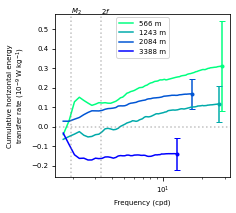

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3.125, 3))

ax.set_ylabel("Cumulative horizontal energy\ntransfer rate ($10^{-9}$ W kg$^{-1}$)")
ax.set_xlabel("Frequency (cpd)")

colors = plt.cm.winter_r(np.linspace(0, 1, cw.N_levels))

# Error should be equally split in frequency bands.. approximately.
F_err = utils.emean(ca.errF_horiz)

for lev in range(ca.N_levels):
    fmin = fcor = np.abs(cc.f) / (np.pi * 2)
    fmax = ca.N[:, lev].mean() / (np.pi * 2)
    use = (cw.freq > fmin) & (cw.freq < fmax)
    freq = cw.freq[use]
    df = np.diff(freq)[0]

    Especs = -ca.sstrain[:, lev] * cw.Cuv[use, :, lev].real
    Especn = -0.5 * ca.nstrain[:, lev] * (cw.Puu[use, :, lev] - cw.Pvv[use, :, lev])
    Espech = Especs + Especn

    # ax.plot(freq/fcor, Especs.mean(axis=-1)*df, 'r.-', label='shear')
    # ax.plot(freq/fcor, Especn.mean(axis=-1)*df, 'b.-', label='normal')
    csum = np.cumsum(1e9 * Espech.mean(axis=-1) * df)
    ax.semilogx(
        freq * 86400,
        csum,
        label="{:1.0f} m".format(-ca.z[:, lev].mean()),
        color=colors[lev],
    )
    ax.errorbar(
        freq[-1] * 86400,
        csum[-1],
        fmt=".",
        yerr=1.96 * 1e9 * F_err[lev],
        color=colors[lev],
        capsize=3,
    )


ax.axvline(M2, color="grey", ls=":", alpha=0.5)
ax.axvline(2 * fcor * 86400, color="grey", ls=":", alpha=0.5)
ax.axhline(0, color="grey", ls=":", alpha=0.5)

ax.annotate("$M_2$", xy=(M2, ax.get_ylim()[1]))
ax.annotate("$2f$", xy=(2 * fcor * 86400, ax.get_ylim()[1]))

ax.legend()

if save_figs:
    fig.savefig(
        os.path.join(fsd, "cum_horiz_transfer.pdf"),
        bbox_inches="tight",
        pad_inches=0.01,
        dpi=300,
    )
    fig.savefig(
        os.path.join(fsd, "cum_horiz_transfer.png"),
        bbox_inches="tight",
        pad_inches=0.01,
        dpi=300,
    )

plt.show()